# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [498]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import  SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve,  ShuffleSplit, RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
#from sklearn.ensemble import HistGradientBoostingClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [499]:
# load in the data
# azdias = pd.read_csv(r'./data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
# customers = pd.read_csv(r'./data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [500]:
# Pickle the data downloaded from the Udacity workspace
# azdias.to_pickle('./data/azdias.pickle')
# customers.to_pickle('./data/customers.pickle')

# Load as pickle
azdias = pd.read_pickle('./data/azdias.pickle')
print(azdias.shape)
customers =pd.read_pickle('./data/customers.pickle')
print(customers.shape)

(891221, 366)
(191652, 369)


In [501]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head(10)
azdias.dtypes

LNR                       int64
AGER_TYP                  int64
AKT_DAT_KL              float64
ALTER_HH                float64
ALTER_KIND1             float64
                         ...   
WOHNDAUER_2008          float64
WOHNLAGE                float64
ZABEOTYP                  int64
ANREDE_KZ                 int64
ALTERSKATEGORIE_GROB      int64
Length: 366, dtype: object

In [503]:
azdias['EINGEFUEGT_AM'].head(5)
pd.to_datetime(azdias['EINGEFUEGT_AM'][2], format='%Y-%m-%d ').year

1992

In [504]:
azdias.isna().sum(axis=1)
azdias.isna().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [505]:
# Differences in columns
set(customers.columns) - set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [506]:
# Show object dtypes
azdias.select_dtypes(['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7.0,41.0,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9.0,51.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4.0,24.0,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9.0,51.0,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [507]:
for c in azdias.select_dtypes(['object']).columns:
    print(c)
    

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ


## Part 0: Data Wrangling and Preprocessing

In [508]:
def drop_col(df, cols_drop):
    """Returns a cleaned dataframe object. And also a summary of the retured df is printed.

    Args:
        df (dataframe): The input dataframe that should be cleaned.
        cols_drop (list): A list of columns that should be dropped_description_
        test (_type_): _description_

    Returns:
        df: A dataframe cleaned by the input cols_drop
    """
    df_clean = df.drop(cols_drop, axis=1, inplace=True)
    #df_clean.isna

    # Print summary
    # print('From an input shape of: {} the returned shape is: {}'.format(df.shape, df_clean.shape))
    # print('The initial datatype were: {}'.format(df.dtypes))
    # print('The output datatype are: {}'.format(df_clean.dtypes))
    return df_clean

In [509]:
def draw_learning_curves(X, y, estimator, num_trainings):
    """
    Draw learning curve that shows the validation and training auc_score of an estimator 
    for varying numbers of training samples.
    
    Input:
        X: array like sample
        y: array like target relative to X2 sample
        estimator: object type that implements the “fit” and “predict” methods
        num_trainings (int): number of training samples to plot
        
    Output:
        None
    """
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring = 'roc_auc', 
        train_sizes=np.linspace(.1, 1.0, num_trainings),
        cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=random_state),
        )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("AUC train score = {}".format(train_scores_mean[-1].round(2)))
    print("AUC validation score = {}".format(test_scores_mean[-1].round(2)))
    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("% of training set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()

In [510]:
# drop null values for a given threshold

def drop_col_based_thres(df, threshold = 0.25):
    """A function that drops all columns based on missing values by a given threshold in percent.

    Args:
        df (dataframe): A input dataframe that should be cleaned for missing values by rows
        threshold (lilst): The threshold in decimal number percent 40% -> 0.4

    Returns:
        df_clean (dataframe): A cleaned version of the input dataframe
    """
    
    # Get the share of null values for each column                     
    null_shares = df.isnull().sum()/len(df)
    # Get the columns with a null share over the threshold
    drop_cols = list(null_shares[null_shares>threshold].index)
    # Clean the df by the identified columns
    df_clean = df.drop(drop_cols, axis=1)
    print('Shape before cleaning {}/nShape after cleaning {}'.format(df.shape, df_clean.shape))            
    return df_clean

def replace_nans(df, col_names: list , col_values:list , replace_value:list ):
    """_summary_

    Args:
        df (dataframe): Input dataframe
        col_names (list): A list of columns which should be proceeded for the replacement
        col_values (list): Search values that should be replaced by replace_value in the same order 
        replace_value (list): A list in the same order als col_values which these should be replaced with

    Returns:
        df_replaced (dataframe): The output dataframe after replacing the values in the columns by the replacement values
    """
    df_replaced = df
    df_new_cols = df[col_names].replace(col_values,-1).fillna(-1).astype(int)
    df_replaced[col_names] = df_new_cols
    #### Handle the remaining categorical variables
    df_replaced['OST_WEST_KZ'].replace('O', 0, inplace=True)
    df_replaced['OST_WEST_KZ'].replace('W', 1, inplace=True)
    df_replaced['OST_WEST_KZ'] = pd.to_numeric(df_replaced['OST_WEST_KZ'], errors = 'coerce')
    
    
    return df_replaced


def timeseries_to_year(df):
    """Converts a columns in a df to datetime type and keeps only the year.

    Args:
        df (dataframe): Input dataframe
        #col_names (list): A list of columns which should be proceeded for converting. Timeseries format is '%Y-%m-%d '

    Returns:
        df_clean (dataframe): A dataframe where the column is converted as a time series with only the year
    """
    df_cleaned = df
    df_cleaned['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year

    return df_cleaned

In [511]:
col_names = ['CAMEO_DEUG_2015','CAMEO_INTL_2015'] #Replace and fill na
col_names_2 = ['CAMEO_DEU_2015','OST_WEST_KZ'] #Fill na
col_values  = ['X', 'XX']
col_replace_values = [-1]

##### Azdias dataframe

In [512]:
# Clean azdias
# Drop columns with not enough data
azdias_cleaned = drop_col_based_thres(azdias)

# Replace nan in cleaned dataframe
# Replace nan in cleaned dataframe
azdias_cleaned = replace_nans(azdias_cleaned, col_names, col_values, col_replace_values)
print(azdias_cleaned[col_names].head(10))

Shape before cleaning (891221, 366)/nShape after cleaning (891221, 350)
   CAMEO_DEUG_2015  CAMEO_INTL_2015
0               -1               -1
1                8               51
2                4               24
3                2               12
4                6               43
5                8               54
6                4               22
7                2               14
8                1               13
9                1               15


In [513]:
azdias_cleaned = timeseries_to_year(azdias_cleaned)

In [514]:
azdias_cleaned['OST_WEST_KZ'].dtype

dtype('float64')

##### Customers dataframe

In [515]:
# Clean customers
# Drop the same values as in azdias for later analysis.

drop_cust_cols  = set(customers.columns) - set(azdias_cleaned.columns)
customers_cleaned = customers.drop( drop_cust_cols, axis=1)
# The columns are dropped in customer dataset due to to many missing values
#customers_cleaned = drop_col_based_thres(customers)


# Replace nan in cleaned dataframe
customers_cleaned = replace_nans(customers_cleaned, col_names, col_values, col_replace_values)
print(customers_cleaned[col_names].head(10))

   CAMEO_DEUG_2015  CAMEO_INTL_2015
0                1               13
1               -1               -1
2                5               34
3                4               24
4                7               41
5                5               34
6                3               23
7                1               15
8                9               55
9                1               15


In [516]:
customers_cleaned.shape

(191652, 350)

In [517]:
customers_cleaned = timeseries_to_year(customers_cleaned)

In [518]:
#customers_cleaned = drop_col(customers_cleaned,['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])


### Several Preprocessing steps need to be done

We genereate a pipeline for each preprocessing. The approach here used is to split the Pipeline by the column data types.
Some data adjustements as well replacements of missing values are needed.

#### Continous Variables:
   + Impute with median since it is more robust to outliers
   + StandardScaler

#### Binary:
   + Clean
   
#### Categorical: 
   + Impute with most frequent since others methods are only for numeric
   + One-Hot Encode the variables



In [519]:
# Get lists of the datatype columns
numerical_cols = list(azdias_cleaned.select_dtypes(['float64','int64']))
categorical_cols = list(azdias_cleaned.select_dtypes(['object']))

In [520]:
# Numerical Pipeline 
num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='median')),
    ('num_scalar', StandardScaler())
])

#### Categorical Pipeline

In [521]:
# Categorical Pipeline 
cat_pipe = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'))
])

#### Combine pipelines

In [522]:
# Preprocessing Pipeline
pre_pipe = [
    #('bin', binary_pipeline, binary_cols),
    ('cat', cat_pipe, categorical_cols),
    ('num', num_pipe, numerical_cols)]

In [523]:
pre_pipe_columntransformer = ColumnTransformer(transformers = pre_pipe)

In [524]:
azdias_cleaned[categorical_cols]

,CAMEO_DEU_2015
0,NaN
1,8A
2,4C
3,2A
4,6B
...,...
891216,7A
891217,9D
891218,4C
891219,9D


#### Run pipelines to transform datasets

In [525]:
azdias_transformed = pre_pipe_columntransformer.fit_transform(azdias_cleaned)

azdias_transformed = pre_pipe_columntransformer.fit_transform(azdias_cleaned)

In [526]:
# Get the column names after the One Hot Encoding
dummy_cols = list(pre_pipe_columntransformer.transformers_[0][1]\
   .named_steps['one_hot_encoding'].get_feature_names(categorical_cols))

In [527]:
all_cols =  dummy_cols +  numerical_cols

In [528]:
# Convert transformation into a new dataframe
azdias_transformed_df = pd.DataFrame(azdias_transformed, columns= all_cols)

In [529]:
# Check if datatypes are all numeric for further processing
azdias_transformed_df.dtypes.value_counts()

float64    392
dtype: int64

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal Component Analysis
As learned in Udacity course with a high dimension data input there a high chanced that the same information is provided
in diffrent columns. To reduce complexity for later modelling a PCA is done at first. 

In [530]:
%%time 
#  Fit PCA such that 95% of the variance is retained.
pca = PCA(.95)
azdias_reduced = pca.fit_transform(azdias_transformed_df)


Wall time: 4min 45s


216


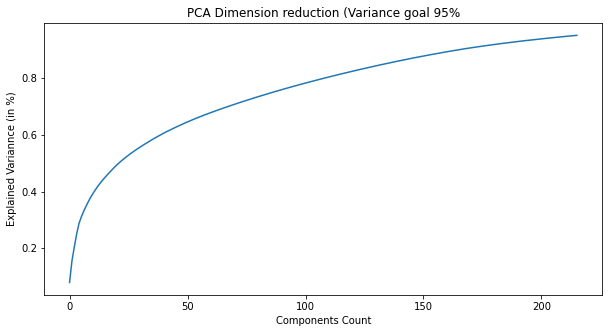

Wall time: 790 ms


In [531]:
%%time
# Show how many data columns are required to retain the given variance
print(pca.n_components_)
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components Count')
plt.ylabel('Explained Variannce (in %)')
plt.title('PCA Dimension reduction (Variance goal 95%')
plt.show()

In [532]:
azdias_reduced_df = pd.DataFrame(azdias_reduced)

### Clustering with k-means 
To cluster unlabeled data this approach is very usefull. To determine the final number of clusters the elbow-method will be used (https://predictivehacks.com/k-means-elbow-method-code-for-python/).

In [533]:
distortions = []
list_k = list(range(1,15))

for k in list_k:
    clustering = KMeans(n_clusters = k, init='k-means++')
    clustering.fit(azdias_transformed_df.sample(10000))
    distortions.append(clustering.inertia_)

#### Plot Elbow for KMeans

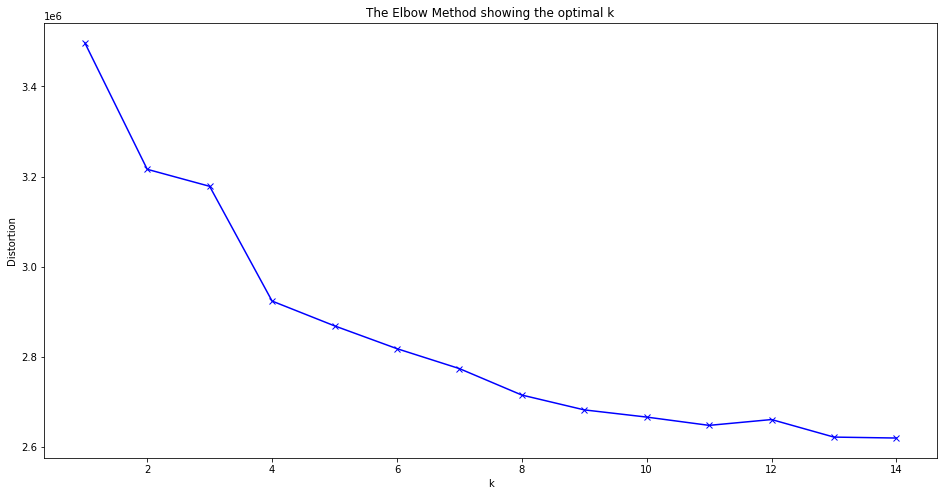

In [534]:
plt.figure(figsize=(16,8))
plt.plot(list_k, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [535]:
#### Transform colums, Reduce PCA, Cluster kMeans Pipleine
T_R_C_pipeline = Pipeline([
    ('transform', pre_pipe_columntransformer),
    ('reduce', pca),
    ('cluster', KMeans(n_clusters = 6, init='k-means++'))
])


In [536]:
# Fit the pipeline on the azdias df
T_R_C_pipeline.fit(azdias_cleaned)


KeyboardInterrupt: 

In [ ]:
azdias_cluster = pd.DataFrame(T_R_C_pipeline.predict(azdias_cleaned), columns= ['Cluster'])

In [541]:
# Fit the pipeline on the customer df
customers_cluster = pd.DataFrame(T_R_C_pipeline.predict(customers_cleaned), columns= ['Cluster'])

KeyboardInterrupt: 

In [ ]:
print('shape {} before '.format(customers_cleaned.shape))
customers_cleaned['Cluster'] = customers_cluster
print('shape {} after '.format(customers_cleaned.shape))

In [538]:
# Safe results to pickle for later loadings
# azdias_cluster.to_pickle('.\data\\azdias_cluster.pickle')
# customers_cluster.to_pickle('.\data\\customer_cluster.pickle')

azdias_cluster = pd.read_pickle('.\data\\azdias_cluster.pickle')
customers_cluster = pd.read_pickle('.\data\\customer_cluster.pickle')

In [543]:
azdias_cleaned['Cluster'] = azdias_cluster

print('shape {} before '.format(customers_cleaned.shape))
customers_cleaned['Cluster'] = customers_cluster
print('shape {} after '.format(customers_cleaned.shape))

shape (191652, 350) before 
shape (191652, 351) after 


In [ ]:
# Pickle the data downloaded from the Udacity workspace
# azdias.to_pickle('./data/azdias.pickle')
# customers.to_pickle('./data/customers.pickle')

# Load as pickle
azdias = pd.read_pickle('./data/azdias.pickle')
print(azdias.shape)
customers =pd.read_pickle('./data/customers.pickle')
print(customers.shape)

(891221, 366)
(191652, 369)


#### Visualize the cluster results

In [544]:
# Get all cluster sizes
population_clusters = azdias_cleaned['Cluster'].value_counts().sort_index()
customer_clusters = customers_cleaned['Cluster'].value_counts().sort_index()

In [545]:
# Concat both df to one for viz.
df_cluster = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
df_cluster.columns = ['cluster_n', 'population_count', 'customers_count']
# df_cluster['cluster']+=1

In [546]:
# Calculate share of each cluster
df_cluster['population_share'] = df_cluster.population_count / df_cluster.population_count.sum()
df_cluster['customers_share'] = df_cluster.customers_count / df_cluster.customers_count.sum()
df_cluster['share_diff'] = df_cluster['customers_share'] - df_cluster['population_share']

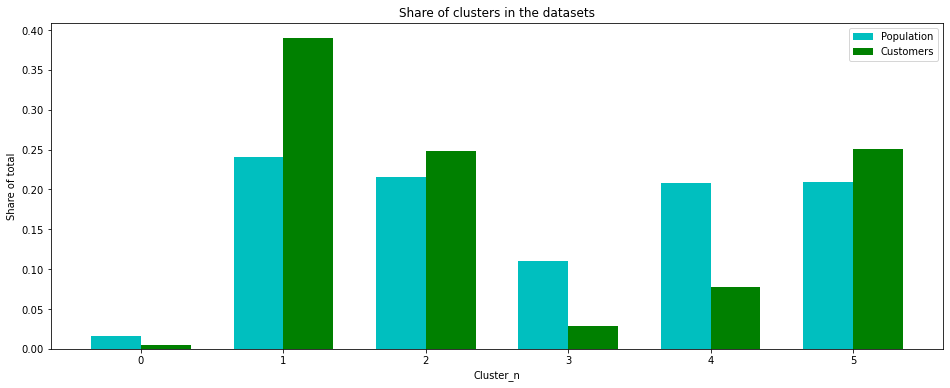

In [547]:
# Plot clusters 
fig, ax = plt.subplots(figsize=(16,6))

ind = np.arange(6)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, df_cluster['population_share'], width, bottom=0, color='c' )
p2 = ax.bar(ind + width, df_cluster['customers_share'], width, bottom=0, color='g')

ax.set_title('Share of clusters in the datasets')
ax.set_ylabel('Share of total')
ax.set_xlabel('Cluster_n')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(df_cluster['cluster_n'])
ax.legend((p1[0], p2[0]), ('Population', 'Customers'))
ax.autoscale_view()

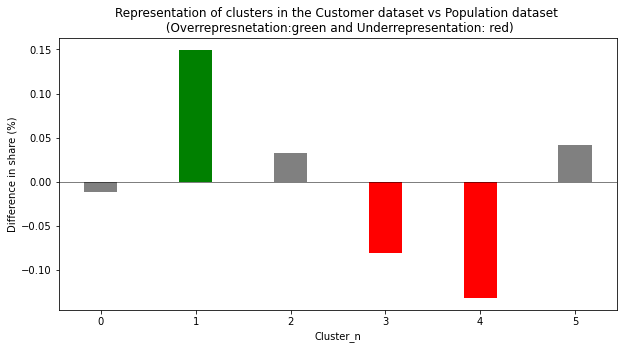

In [548]:
# Plot diffrence between cluster and dataframes
fig, ax = plt.subplots(figsize=(10,5))

ind = np.arange(6)    # the x locations for the groups
width = 0.35         # the width of the bars

bar_colors = ('grey','green','grey','red','red','grey')

p1 = ax.bar(ind, df_cluster['share_diff'], width, color = bar_colors)

ax.set_title('Representation of clusters in the Customer dataset vs Population dataset \n (Overrepresnetation:green and Underrepresentation: red)')

ax.set_ylabel('Difference in share (%)')
ax.set_xlabel('Cluster_n')
ax.axhline(linewidth=.5, color='black')

ax.set_xticks(ind)
ax.set_xticklabels(df_cluster['cluster_n']);

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [549]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

c:\Users\heuse\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [550]:
set(mailout_train.columns) - set(azdias_cleaned.columns)

{'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'RESPONSE'}

In [551]:
# Clean and Merge mail train
# Clean mail
# Drop the same values as in azdias for later analysis.

drop_mail_cols  = set(mailout_train.columns) - set(azdias_cleaned.columns)
mailout_train_cleaned = mailout_train.drop(drop_mail_cols, axis=1)
mailout_train_cleaned['RESPONSE'] = mailout_train['RESPONSE']

# The columns are dropped in customer dataset due to to many missing values



# Replace nan in cleaned dataframe
mailout_train_cleaned = replace_nans(mailout_train_cleaned, col_names, col_values, col_replace_values)

In [552]:
mailout_train_cleaned = timeseries_to_year(mailout_train_cleaned)

In [553]:
mailout_train_cleaned.shape

(42962, 351)

### Get X and y

In [554]:
# Get data matrix X and output array y
X = mailout_train_cleaned.drop('RESPONSE', axis=1)
y = mailout_train_cleaned['RESPONSE']

In [555]:
# Train several models for the RESPONSE column
unsupervised_models = {
    # 'HistGradientBoostingClassifier' : HistGradientBoostingClassifier(
    #         verbose=1,
    #         random_state=random_state, 
    #         warm_start=True),
    'GradientBoostingClassifier': GradientBoostingClassifier(verbose=1,
         random_state=random_state,
         n_estimators = 10,
         subsample=0.6,
         tol=0.01),
    'RandomForestClassifier': RandomForestClassifier(
        random_state=random_state,
        verbose=1,
        max_samples= 0.5,
        n_jobs=4,
        warm_start=True)
#      'XGBClassifier': xgb.XGBClassifier(),
    }

In [556]:
for m_key, m_value in unsupervised_models.items():
    print('Name is:    {}\nObject is:  {}'.format(m_key, m_value ))

Name is:    GradientBoostingClassifier
Object is:  GradientBoostingClassifier(n_estimators=10, random_state=42, subsample=0.6,
                           tol=0.01, verbose=1)
Name is:    RandomForestClassifier
Object is:  RandomForestClassifier(max_samples=0.5, n_jobs=4, random_state=42, verbose=1,
                       warm_start=True)


GradientBoostingClassifier
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0997          -0.0194            0.75s
         2           0.0906          -0.0012            0.59s
         3           0.1104          -0.0074            0.49s
         4           0.1070          -0.0028            0.41s
         5           0.0796          -0.0004            0.34s
         6           0.0756          -0.0036            0.27s
         7           0.0935           0.0001            0.21s
         8           0.0850           0.0003            0.14s
         9           0.0807          -0.0137            0.07s
        10           0.0728           0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1110           0.0001            1.77s
         2           0.1079          -0.0126            1.41s
         3           0.1093          -0.0011            1.18s
         4           0.1102           0.0

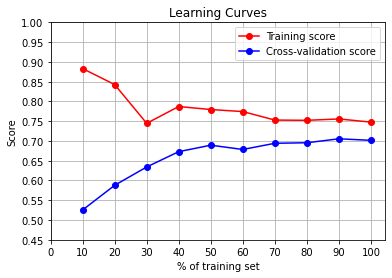

RandomForestClassifier


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
c:\Users\heuse\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  if hasattr(base_class, "_more_tags"):
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
c:\User

AUC train score = 1.0
AUC validation score = 0.58



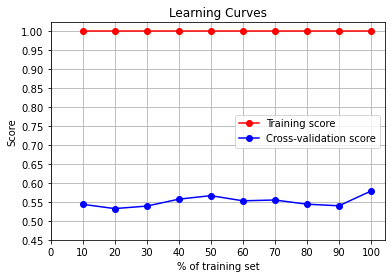

In [557]:
for key_m, m_value in unsupervised_models.items():
    print(key_m)
    ml_pipeline = Pipeline([
        ('transform', pre_pipe_columntransformer),
        ('model', m_value)
    ])
    #X, y = randomize(mailout_train_cleaned)
    draw_learning_curves(X, y, ml_pipeline, 10)

### Hyperparamter tunig for the final model

In [558]:
# define hyperparamters
final_pipeline = gbc_pipeline = Pipeline([
    ('transform', pre_pipe_columntransformer),
    ('classifier', GradientBoostingClassifier(max_depth=2 ,verbose=2))
])
tuning_paramters = {
    'classifier__subsample' : [0.5, 0.75],
    'classifier__n_estimators': [100],
    'classifier__max_depth': [2,3],
    'classifier__min_samples_split': [2,4]

}

In [559]:
# search parameters
# 
randSCV =  RandomizedSearchCV(final_pipeline, tuning_paramters, 
    scoring = 'roc_auc',
    n_iter = 5,
    verbose=2
    )

In [560]:
search = randSCV.fit(X,y)
search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1292           0.0012            1.84m
         2           0.1255           0.0011            1.92m
         3           0.1260           0.0009            1.95m
         4           0.1284           0.0006            1.84m
         5           0.1257           0.0005            1.81m
         6           0.1275           0.0002            1.74m
         7           0.1285           0.0003            1.72m
         8           0.1292          -0.0001            1.65m
         9           0.1235           0.0003            1.63m
        10           0.1231           0.0000            1.69m
        11           0.1234           0.0000            1.67m
        12           0.1214          -0.0000            1.64m
        13           0.1210          -0.0003            1.67m
        14           0.1226          -0.0011            1.63m
        1

{'classifier__subsample': 0.75,
 'classifier__n_estimators': 100,
 'classifier__min_samples_split': 2,
 'classifier__max_depth': 2}

In [561]:
# Use the searched best parameters for predciting
best_search = search.best_params_
best_predict = search.predict_proba(X)[:,1] 

In [563]:
roc_auc_score(y,best_predict)

0.8049643685575002

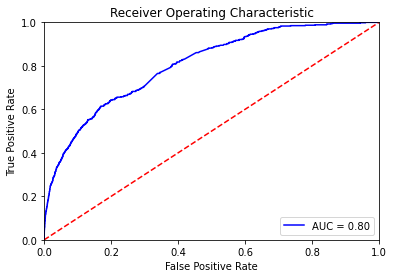

In [564]:
import sklearn.metrics as metrics
preds = best_predict
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [565]:
search.best_estimator_[1].feature_importances_

array([0.0067824 , 0.00733788, 0.        , 0.        , 0.00182872,
       0.00190064, 0.00484241, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00855003, 0.        , 0.        , 0.00205215, 0.        ,
       0.00566793, 0.0081773 , 0.        , 0.00168187, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00219241,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00218014, 0.        , 0.        ,
       0.01846545, 0.        , 0.00709783, 0.00196148, 0.00897937,
       0.01223393, 0.04607058, 0.00178384, 0.00771862, 0.02805513,
       0.        , 0.        , 0.0043397 , 0.00251078, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00490504, 0.01229844, 0.        , 0.00391884, 0.        ,
       0.        , 0.        , 0.00192981, 0.        , 0.     

In [566]:
final_cols = all_cols

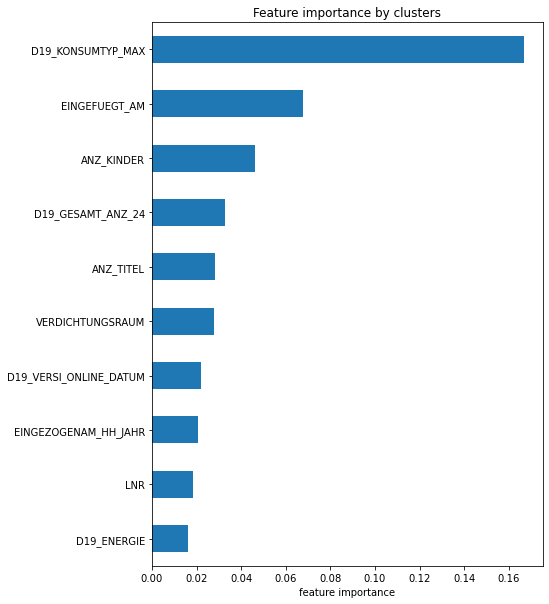

In [567]:
feature_importances = search.best_estimator_[1].feature_importances_
pd.Series(feature_importances, index=final_cols).sort_values()[-10:].plot(kind='barh', figsize=(7,10))
plt.xlabel('feature importance')
plt.title('Feature importance by clusters');

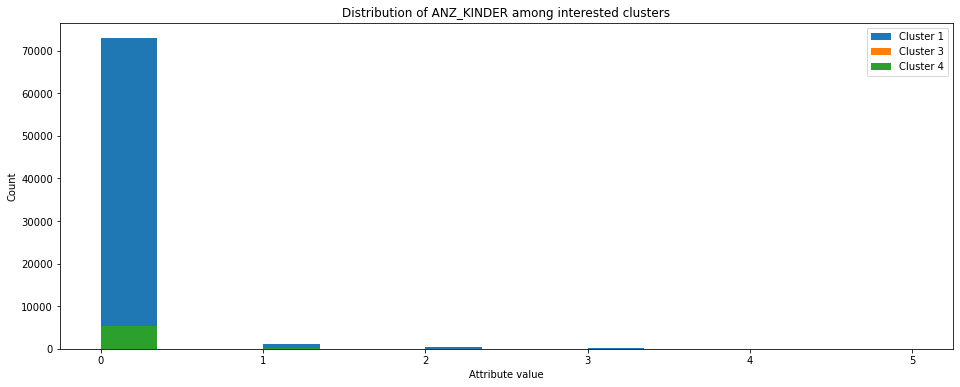

In [568]:
# Plot ANZ_KINDER distribution in relevant clusters
x1=customers_cleaned.iloc[customers_cleaned[customers_cleaned['Cluster'] == 1].index]['ANZ_KINDER']
x2=customers_cleaned.iloc[customers_cleaned[customers_cleaned['Cluster'] == 3].index]['ANZ_KINDER']
x3=customers_cleaned.iloc[customers_cleaned[customers_cleaned['Cluster'] == 4].index]['ANZ_KINDER']

# x1=customers_cleaned.iloc[customers_cleaned.index]['ANZ_KINDER']
# x2=customers_cleaned.iloc[customers_cleaned.index]['ANZ_KINDER']

fig, ax = plt.subplots(figsize=(16,6))

width = 0.35 

p1 = plt.hist(x1, width=width, label='Cluster 1')
p2 = plt.hist(x2, width=width, label='Cluster 3')
p3 = plt.hist(x2, width=width, label='Cluster 4')

plt.title('Distribution of ANZ_KINDER among interested clusters')
plt.ylabel('Count')
plt.xlabel('Attribute value')
plt.legend()

# References

+ https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
+ https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
+ https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
+ https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
+ https://stackoverflow.com/questions/28501072/how-to-check-which-version-of-nltk-scikit-learn-installed
+ https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py
+ https://www.anyscale.com/blog/how-to-speed-up-scikit-learn-model-training
+ https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
+ https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python